#### Analyzing Neural Time Series Data
Python code for Chapter 22 -- converted from original Matlab by AE Studio (and ChatGPT)\
Original Matlab code by Mike X Cohen

This code accompanies the book, titled "Analyzing Neural Time Series Data" (MIT Press).\
Using the code without following the book may lead to confusion, incorrect data analyses, and misinterpretations of results.\
Mike X Cohen and AE Studio assume no responsibility for inappropriate or incorrect use of this code.

In [33]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.spatial.distance import pdist, squareform
from scipy.special import legendre
from scipy.fftpack import fft, ifft
from numpy.linalg import inv, pinv
from mne import create_info
from mne.channels import make_dig_montage
from mne.viz import plot_topomap
from mne.transforms import apply_trans

In [11]:
# Load sample EEG dataset
EEG = loadmat('../data/sampleEEGdata.mat')['EEG'][0, 0]

# Compute inter-electrode distances
interelectrodedist = np.zeros((EEG['nbchan'][0][0], EEG['nbchan'][0][0]))
for chani in range(EEG['nbchan'][0][0]):
    for chanj in range(chani + 1, EEG['nbchan'][0][0]):
        interelectrodedist[chani, chanj] = np.sqrt(
            (EEG['chanlocs'][0][chani]['X'][0][0] - EEG['chanlocs'][0][chanj]['X'][0][0]) ** 2 +
            (EEG['chanlocs'][0][chani]['Y'][0][0] - EEG['chanlocs'][0][chanj]['Y'][0][0]) ** 2 +
            (EEG['chanlocs'][0][chani]['Z'][0][0] - EEG['chanlocs'][0][chanj]['Z'][0][0]) ** 2
        )

valid_gridpoints = np.where(interelectrodedist > 0)

# Extract XYZ coordinates from EEG structure
X = np.array([chan['X'][0][0] for chan in EEG['chanlocs'][0]])
Y = np.array([chan['Y'][0][0] for chan in EEG['chanlocs'][0]])
Z = np.array([chan['Z'][0][0] for chan in EEG['chanlocs'][0]])

In [12]:
# Define the laplacian_perrinX function in Python
def laplacian_perrinX(data, x, y, z, leg_order=None, smoothing=1e-5):
    numelectrodes = len(x)
    
    # Set default parameters for +/- 100 electrodes
    if numelectrodes > 100:
        m = 3
        leg_order = 40 if leg_order is None else leg_order
    else:
        m = 4
        leg_order = 20 if leg_order is None else leg_order
    
    # Scale XYZ coordinates to unit sphere
    maxrad = np.max(np.sqrt(x**2 + y**2 + z**2))
    x = x / maxrad
    y = y / maxrad
    z = z / maxrad
    
    # Initialize G, H, and cosdist matrices
    G = np.zeros((numelectrodes, numelectrodes))
    H = np.zeros((numelectrodes, numelectrodes))
    cosdist = np.zeros((numelectrodes, numelectrodes))
    
    # Compute cosdist matrix
    for i in range(numelectrodes):
        for j in range(i + 1, numelectrodes):
            cosdist[i, j] = 1 - (((x[i] - x[j])**2 + (y[i] - y[j])**2 + (z[i] - z[j])**2) / 2)
    cosdist = cosdist + cosdist.T + np.eye(numelectrodes)
    
    # Compute Legendre polynomial
    legpoly = np.zeros((leg_order, numelectrodes, numelectrodes))
    for ni in range(1, leg_order + 1):
        temp = legendre(ni)(cosdist)
        legpoly[ni - 1, :, :] = temp
    
    # Precompute electrode-independent variables
    twoN1 = 2 * (np.arange(1, leg_order + 1)) + 1
    gdenom = (np.arange(1, leg_order + 1) * (np.arange(1, leg_order + 1) + 1))**m
    hdenom = (np.arange(1, leg_order + 1) * (np.arange(1, leg_order + 1) + 1))**(m - 1)
    
    # Compute G and H matrices
    for i in range(numelectrodes):
        for j in range(i, numelectrodes):
            g = np.sum(twoN1 * legpoly[:, i, j] / gdenom)
            h = -np.sum(twoN1 * legpoly[:, i, j] / hdenom)
            G[i, j] = g / (4 * np.pi)
            H[i, j] = -h / (4 * np.pi)
    
    # Mirror matrix
    G = G + G.T
    H = H + H.T
    
    # Correct for diagonal-double
    G = G - np.eye(numelectrodes) * G[0, 0] / 2
    H = H - np.eye(numelectrodes) * H[0, 0] / 2
    
    # Reshape data to electrodes X time/trials
    orig_data_size = data.shape
    data = data.reshape(orig_data_size[0], -1)
    
    # Add smoothing constant to diagonal
    Gs = G + np.eye(numelectrodes) * smoothing
    
    # Compute C matrix
    Gs_inv = inv(Gs)
    Gs_inv_sum = np.sum(Gs_inv, axis=1)
    data_Gs = data.T @ Gs_inv
    C = data_Gs - (np.sum(data_Gs, axis=1) / np.sum(Gs_inv_sum))[:, None] * Gs_inv_sum
    
    # Compute surface Laplacian (and reshape to original data size)
    surf_lap = (C @ H.T).T.reshape(orig_data_size)
    
    return surf_lap, G, H

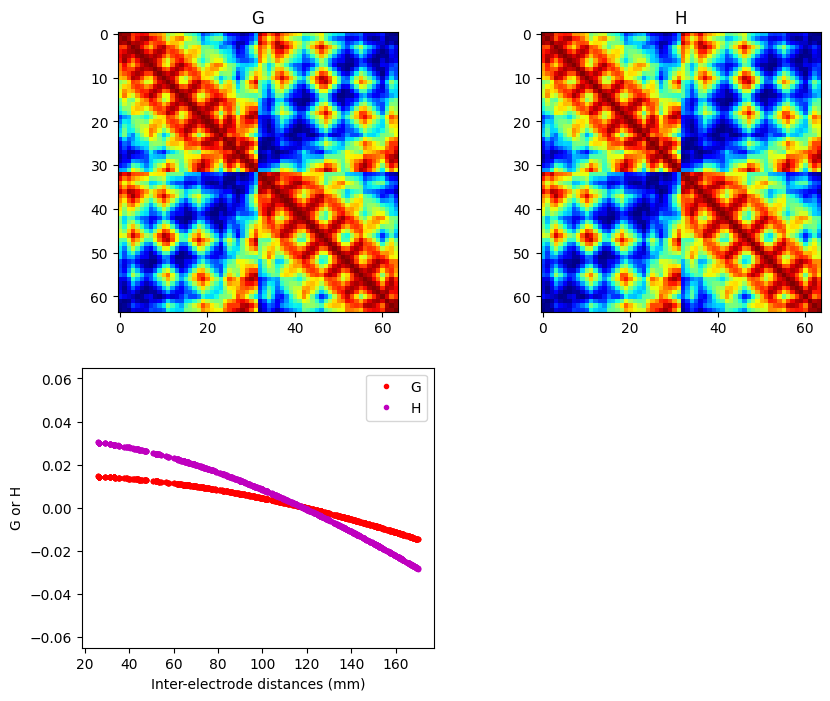

In [13]:
surf_lap, G, H = laplacian_perrinX(np.random.rand(len(X)), X, Y, Z, smoothing=1e-6)

# Plot G and H matrices
plt.figure(figsize=(10, 8))
plt.subplot(221)
plt.imshow(G, cmap='jet')
plt.title('G')

plt.subplot(222)
plt.imshow(H, cmap='jet')
plt.title('H')

plt.subplot(223)
plt.plot(interelectrodedist[valid_gridpoints], G[valid_gridpoints], 'r.')
plt.plot(interelectrodedist[valid_gridpoints], H[valid_gridpoints], 'm.')
plt.legend(['G', 'H'])
plt.ylim([-0.065, 0.065])
plt.xlabel('Inter-electrode distances (mm)')
plt.ylabel('G or H')
plt.show()

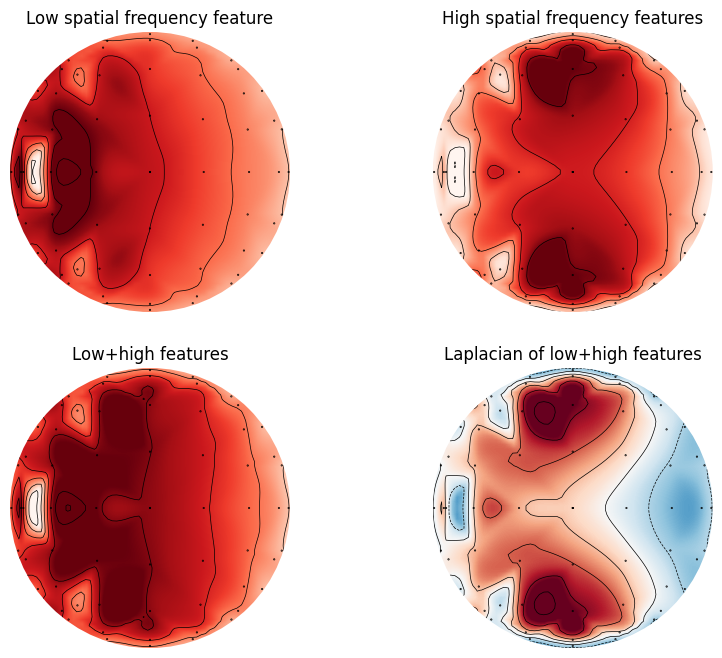

In [14]:
# Define a function to compute Euclidean distances between channels
def compute_euclidean_distances(chanlocs, chan1, chan2=None):
    chan1_idx = np.where(np.array([chan['labels'][0] for chan in chanlocs]) == chan1)[0][0]
    eucdist1 = np.sqrt(
        (X - chanlocs[chan1_idx]['X'][0][0]) ** 2 +
        (Y - chanlocs[chan1_idx]['Y'][0][0]) ** 2 +
        (Z - chanlocs[chan1_idx]['Z'][0][0]) ** 2
    )
    if chan2:
        chan2_idx = np.where(np.array([chan['labels'][0] for chan in chanlocs]) == chan2)[0][0]
        eucdist2 = np.sqrt(
            (X - chanlocs[chan2_idx]['X'][0][0]) ** 2 +
            (Y - chanlocs[chan2_idx]['Y'][0][0]) ** 2 +
            (Z - chanlocs[chan2_idx]['Z'][0][0]) ** 2
        )
        return eucdist1, eucdist2
    return eucdist1

# Example usage for channels 'Pz', 'C4', and 'C3'
eucdist1, eucdist2 = compute_euclidean_distances(EEG['chanlocs'][0], 'Pz', 'C4')
eucdist3 = compute_euclidean_distances(EEG['chanlocs'][0], 'C3')

# Compute spatial frequencies
hi_spatfreq = 2 * np.exp(-eucdist1 ** 2 / (2 * 95 ** 2))
lo_spatfreq = np.exp(-eucdist2 ** 2 / (2 * 50 ** 2)) + np.exp(-eucdist3 ** 2 / (2 * 50 ** 2))
surf_lap_all = laplacian_perrinX(hi_spatfreq + lo_spatfreq, X, Y, Z)

chanlocs = np.array([[x[0][0], y[0][0]] for x, y in zip(EEG['chanlocs'][0]['X'], EEG['chanlocs'][0]['Y'])])

# Plot topographic maps using plot_topomap
plt.figure(figsize=(10, 8))
ax1 = plt.subplot(221)
plot_topomap(hi_spatfreq, chanlocs, axes=ax1, show=False)
plt.title('Low spatial frequency feature')

ax2 = plt.subplot(222)
plot_topomap(lo_spatfreq, chanlocs, axes=ax2, show=False)
plt.title('High spatial frequency features')

ax3 = plt.subplot(223)
plot_topomap(hi_spatfreq + lo_spatfreq, chanlocs, axes=ax3, show=False)
plt.title('Low+high features')

ax4 = plt.subplot(224)
plot_topomap(surf_lap_all[0], chanlocs, axes=ax4, show=False)
plt.title('Laplacian of low+high features')
plt.show()

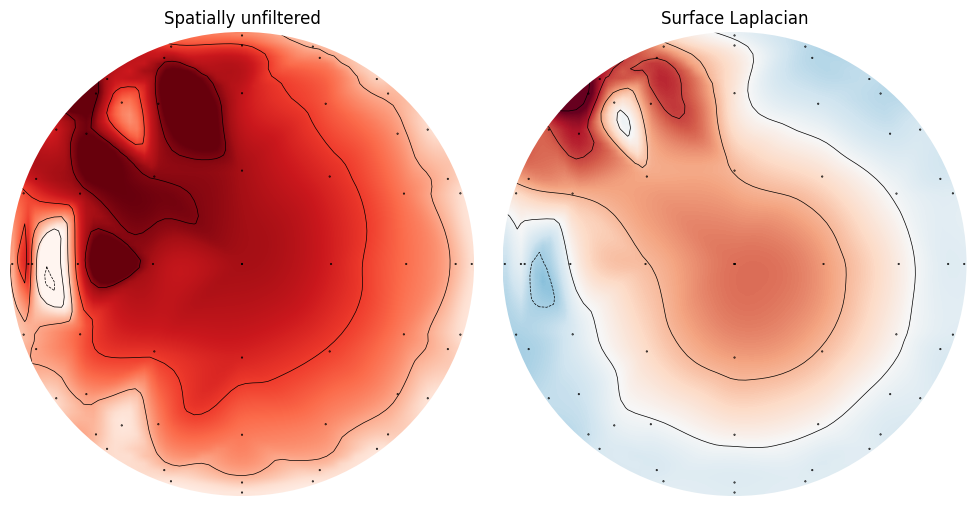

In [17]:
# Another example similar to Figure 4 using channels 'cz' and 'p5'

# Define channels for analysis
chan1 = 'Cz'
chan2 = 'P5'

# Compute Euclidean distances for the specified channels
eucdist1, eucdist2 = compute_euclidean_distances(EEG['chanlocs'][0], chan1, chan2)

# Compute data to use
data2use = np.exp(-eucdist1 ** 2 / (2 * 65 ** 2)) + np.exp(-eucdist2 ** 2 / (2 * 50 ** 2))

# Compute surface Laplacian
surf_lap = laplacian_perrinX(data2use, X, Y, Z)

# Plot topographic maps using plot_topomap
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plot_topomap(data2use, chanlocs, axes=ax[0], show=False)
ax[0].set_title('Spatially unfiltered')

plot_topomap(surf_lap[0], chanlocs, axes=ax[1], show=False)
ax[1].set_title('Surface Laplacian')
plt.tight_layout()
plt.show()

In [18]:
# Helper function to convert Cartesian coordinates to spherical coordinates
def cart2sph(x, y, z):
    hxy = np.hypot(x, y)
    r = np.hypot(hxy, z)
    el = np.arctan2(z, hxy)
    az = np.arctan2(y, x)
    return az, el, r

def laplacian_nola(x, y, z, data, smoothing=100):
    """
    Compute surface Laplacian of EEG data via New Orleans method.
    
    Parameters:
    x, y, z : x, y, z coordinates of electrode positions
    data : EEG data (can be N-D, but first dimension must be electrodes)
    smoothing : smoothing parameter (default: 100)
    
    Returns:
    surf_lap : the surface Laplacian (second spatial derivative)
    """
    n = len(x)
    
    # Budge zero values
    x[x == 0] = 0.001
    y[y == 0] = 0.001
    z[z == 0] = 0.001
    
    # Compute K
    k = np.zeros((n, n))
    for i in range(n):
        for j in range(i + 1, n):
            s = x[i] - x[j]
            t = y[i] - y[j]
            r = z[i] - z[j]
            str = s**2 + t**2 + r**2
            k[i, j] = ((str + smoothing)**2) * np.log(str + smoothing)
    k += k.T
    kinv = pinv(k)
    
    # Compute E and A
    e = np.vstack((np.ones(n), x, y, x**2, x*y, y**2, z, z*x, z*y, z**2)).T
    ke = kinv @ e
    a = e.T @ ke
    ainv = pinv(a)
    
    # Compute Laplacian over data
    orig_data_size = data.shape
    data = data.reshape(orig_data_size[0], -1)
    surf_lap = np.zeros_like(data)
    
    for ti in range(data.shape[1]):
        kv = kinv @ data[:, ti]
        ev = e.T @ kv
        q = ainv @ ev
        eq = e @ q
        keq = kinv @ eq
        p = kv - keq
        
        # Compute Laplacian
        az, el, r = cart2sph(x, y, z)
        el = np.pi / 2 - el
        
        # Trig functions
        st = np.sin(el)
        ct = np.cos(el)
        sp = np.sin(az)
        cp = np.cos(az)
        
        uuxyz = (2 * q[3] + 2 * q[5] + 2 * q[9] - 
                 (2 * st * (q[1] * cp + q[2] * sp) / r + 
                  2 * q[6] * ct / r + 
                  6 * st**2 * (q[3] * cp**2 + q[5] * sp**2 + q[4] * sp * cp) + 
                  6 * st * ct * (q[7] * cp + q[8] * sp) + 
                  6 * q[9] * ct**2))
        
        ttcomp = np.zeros_like(st)
        rrcomp = np.zeros_like(st)
        
        for j in range(n):
            a = r[j] * (st * cp - np.sin(el[j]) * np.cos(az[j]))
            b = r[j] * (st * sp - np.sin(el[j]) * np.sin(az[j]))
            c = r[j] * (ct - np.cos(el[j]))
            
            str = a**2 + b**2 + c**2
            strw = str + smoothing**2
            
            comterm = 4 * str / strw - (str / strw)**2 + 2 * np.log(strw)
            comterm2 = 2 * (2 * str * np.log(strw) + (str**2) / strw)
            
            tcomp = 3 * comterm2 + 4 * str * comterm
            dr = 2 * (a * st * cp + b * st * sp + c * ct)
            
            rcomp = dr * comterm2 + 2 * r[j] * comterm2 / 2 + r[j] * (dr**2) * comterm
            ttcomp += p[j] * tcomp
            rrcomp += p[j] * rcomp / r[j]
        
        surf_lap[:, ti] = -(ttcomp + uuxyz - rrcomp)
    
    surf_lap = surf_lap.reshape(orig_data_size)
    return surf_lap

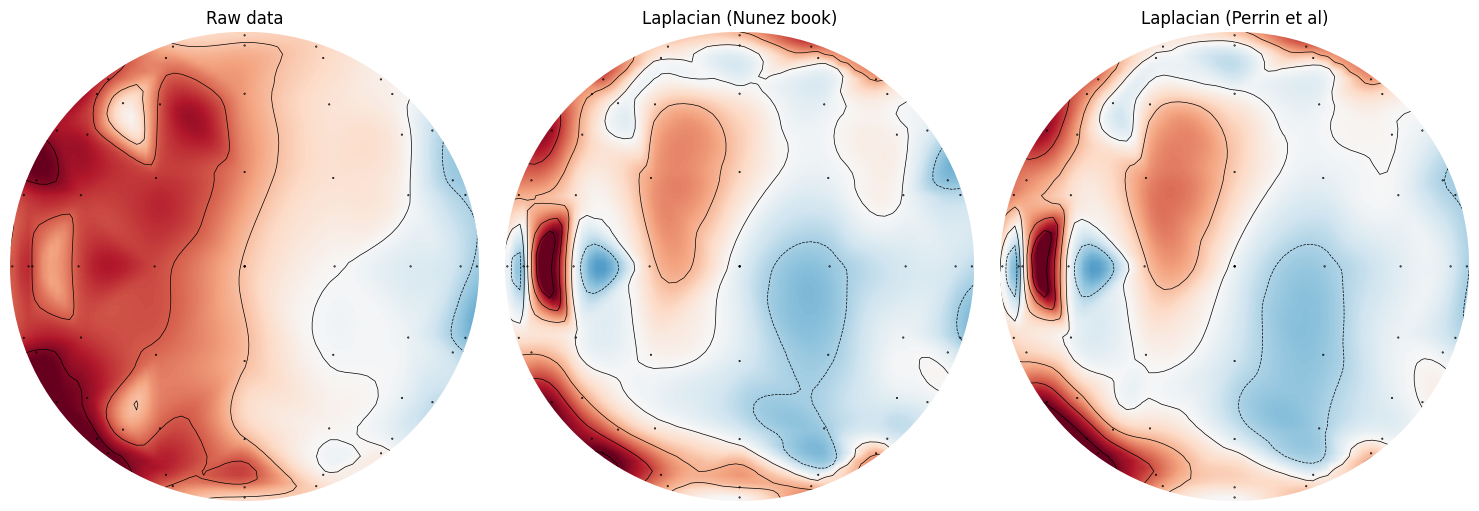

Spatial correlation: r=0.9811306165017355


In [24]:
# Figure 22.5: Laplacian using Nunez and Perrin methods

# Use the mean of the EEG data at a specific time point
data2use = np.mean(EEG['data'][:, 321, :], axis=1).squeeze()

# Compute surface Laplacian using Nunez and Perrin methods
# Note: laplacian_nola function would also need to be implemented in Python.
surf_lapN = laplacian_nola(X, Y, Z, data2use, smoothing=100)
surf_lapP = laplacian_perrinX(data2use, X, Y, Z, smoothing=1e-5)

# Plot topographic maps using plot_topomap
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
plot_topomap(data2use, chanlocs, axes=ax[0], show=False)
ax[0].set_title('Raw data')

plot_topomap(surf_lapN, chanlocs, axes=ax[1], show=False)
ax[1].set_title('Laplacian (Nunez book)')

plot_topomap(surf_lapP[0], chanlocs, axes=ax[2], show=False)
ax[2].set_title('Laplacian (Perrin et al)')
plt.tight_layout()
plt.show()

# Display spatial correlation between the two Laplacian methods
spatial_corr = np.corrcoef(surf_lapN, surf_lapP[0])[0, 1]
print(f"Spatial correlation: r={spatial_corr}")

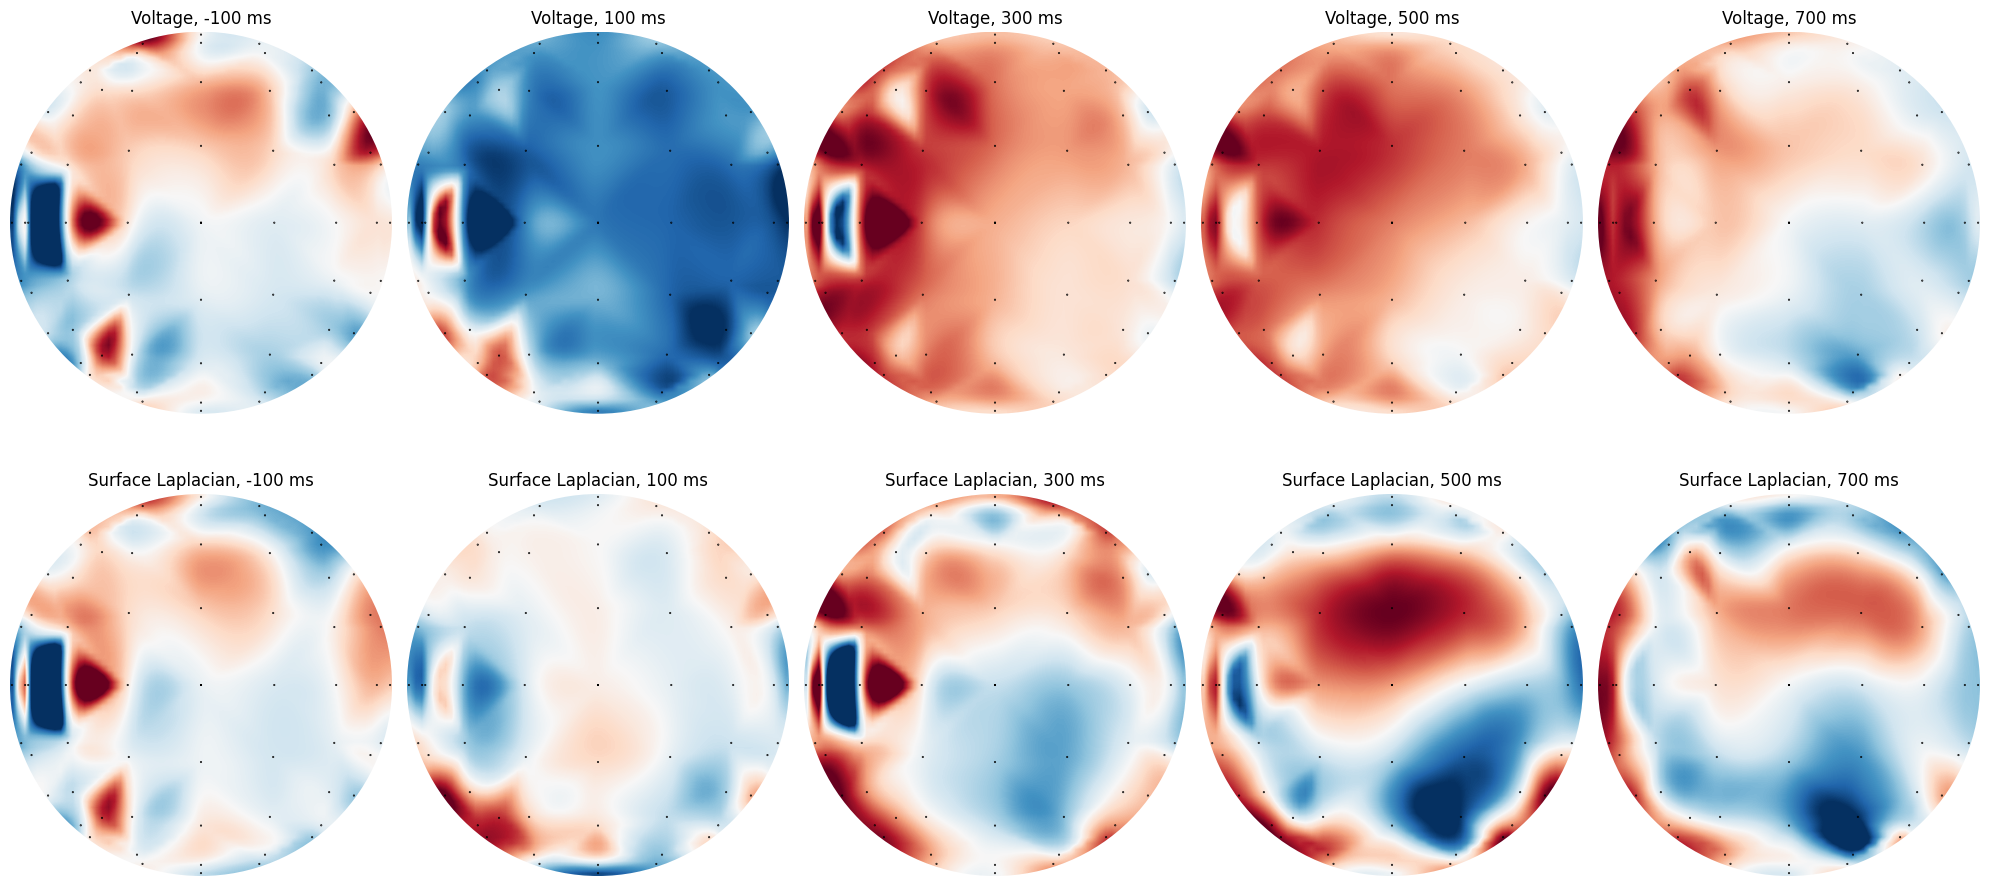

In [27]:
# Figure 22.6: Time test for Perrin and New Orleans methods

# Time test for Perrin and New Orleans methods
# Note: The timing code is not shown here, but you can use Python's time module to measure execution time.

# Define times to plot
times2plot = np.arange(-100, 900, 200)

# Plot voltage and Laplacian maps at different time points
fig, ax = plt.subplots(2, len(times2plot), figsize=(20, 10))
for i, time_point in enumerate(times2plot):
    # Find time index
    timeidx = np.argmin(np.abs(EEG['times'] - time_point))
    
    # Get the mean data at the specified time point
    tempdata = np.mean(EEG['data'][:, timeidx, :], axis=1).squeeze()
    
    # Plot voltage map (spatially unfiltered)
    ax_topo = ax[0, i]
    plot_topomap(tempdata, chanlocs, axes=ax_topo, show=False, contours=0)
    ax_topo.set_title(f'Voltage, {time_point} ms')
    
    # Plot Laplacian map (spatially filtered)
    ax_topo_lap = ax[1, i]
    laplacian_data = laplacian_perrinX(tempdata, X, Y, Z)
    plot_topomap(laplacian_data[0], chanlocs, axes=ax_topo_lap, show=False, contours=0)
    ax_topo_lap.set_title(f'Surface Laplacian, {time_point} ms')

plt.tight_layout()
plt.show()

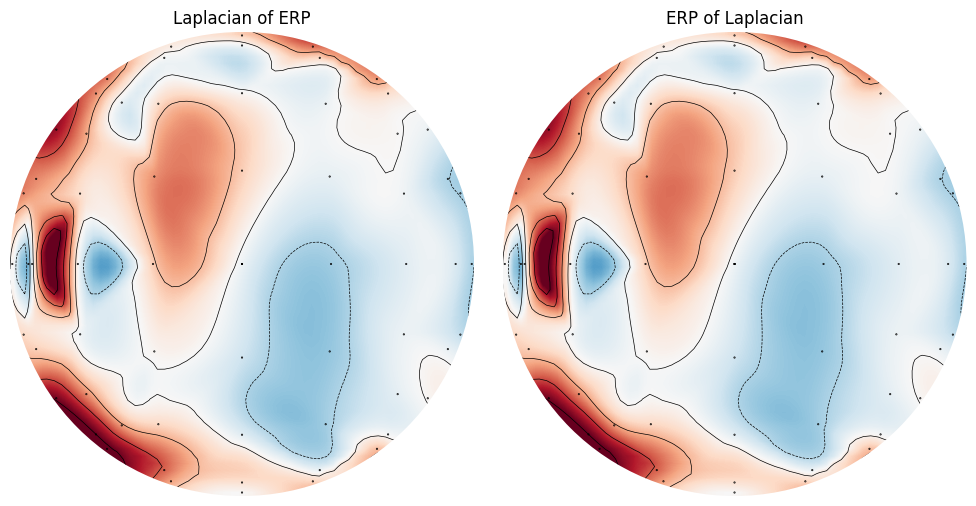

In [31]:
# Brief aside: Computing the Laplacian of the ERP is the same as computing the Laplacian of single trials and then taking the ERP

# Compute the Laplacian of the ERP
erp_laplacian = laplacian_perrinX(np.mean(EEG['data'][:, 321, :], axis=1), X, Y, Z)

# Compute the Laplacian of single trials and then take the ERP
single_trials_laplacian = laplacian_perrinX(EEG['data'][:, 321, :], X, Y, Z)
mean_laplacian = np.mean(single_trials_laplacian[0], axis=1)

# Plot the comparison
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plot_topomap(erp_laplacian[0], chanlocs, axes=ax[0], show=False)
ax[0].set_title('Laplacian of ERP')

plot_topomap(mean_laplacian, chanlocs, axes=ax[1], show=False)
ax[1].set_title('ERP of Laplacian')
plt.tight_layout()
plt.show()

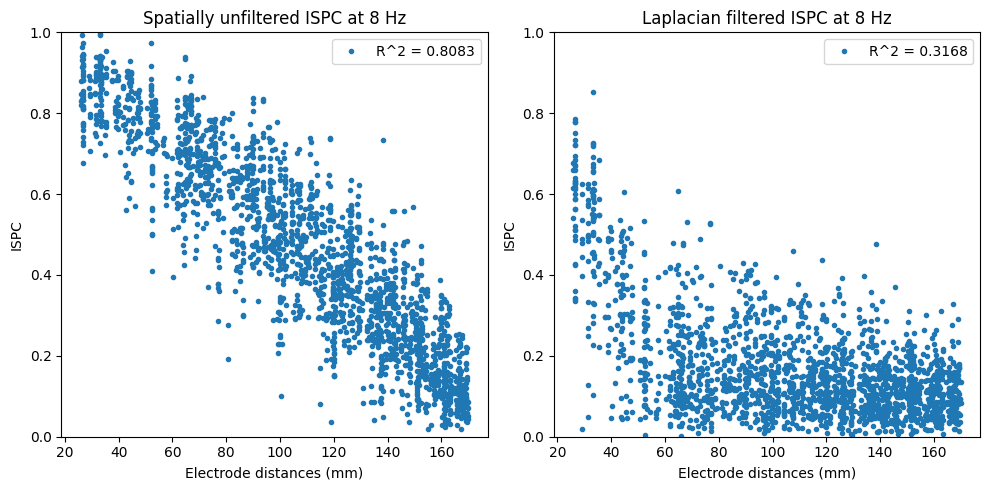

In [43]:
# Figure 22.7: Compute ISPC (inter-site phase clustering) for raw and Laplacian-filtered data

# Compute Laplacian-filtered data for all channels
lap_data, G, H = laplacian_perrinX(EEG['data'], X, Y, Z)
    
# Define frequency and time of interest
freq2use = 8  # Hz
time2use = 400  # ms

# FFT parameters
time = np.arange(-1, 1 + 1/EEG['srate'][0][0], 1/EEG['srate'][0][0])
n_wavelet = len(time)
n_data = EEG['pnts'][0][0] * EEG['trials'][0][0]
n_convolution = n_wavelet + n_data - 1
n_conv2 = 2**int(np.ceil(np.log2(n_convolution)))

# Create wavelet and get FFT
wavelet_fft = fft(np.exp(2 * 1j * np.pi * freq2use * time) * np.exp(-time ** 2 / (2 * (4 / (2 * np.pi * freq2use)) ** 2)) / freq2use, n_conv2)
half_of_wavelet_size = (len(time) - 1) // 2

# Initialize
allphases_pre = np.zeros(EEG['data'].shape, dtype=complex)
allphases_lap = np.zeros(EEG['data'].shape, dtype=complex)
ispc_pre = np.zeros((EEG['nbchan'][0][0], EEG['nbchan'][0][0]))
ispc_lap = np.zeros((EEG['nbchan'][0][0], EEG['nbchan'][0][0]))
timeidx = np.argmin(np.abs(EEG['times'] - time2use))

# Get all phases
for chani in range(EEG['nbchan'][0][0]):
    # First for nonspatially filtered data
    fft_data = fft(np.reshape(EEG['data'][chani, :, :], (1, n_data), 'F'), n_conv2)
    conv_res = ifft(wavelet_fft * fft_data, n_conv2)
    conv_res = conv_res[:, :n_convolution]
    conv_res = conv_res[:, half_of_wavelet_size:-half_of_wavelet_size]
    allphases_pre[chani, :, :] = np.reshape(conv_res, (EEG['pnts'][0][0], EEG['trials'][0][0]), 'F')
    
    # Then for Laplacian filtered data
    fft_data = fft(np.reshape(lap_data[chani, :, :], (1, n_data), 'F'), n_conv2)
    conv_res = ifft(wavelet_fft * fft_data, n_conv2)
    conv_res = conv_res[:, :n_convolution]
    conv_res = conv_res[:, half_of_wavelet_size:-half_of_wavelet_size]
    allphases_lap[chani, :, :] = np.reshape(conv_res, (EEG['pnts'][0][0], EEG['trials'][0][0]), 'F')

# Compute synchrony
for chani in range(EEG['nbchan'][0][0]):
    for chanj in range(chani + 1, EEG['nbchan'][0][0]):
        # Cross-spectral density for nonspatially filtered data
        cd_pre = allphases_pre[chani, timeidx, :] * np.conj(allphases_pre[chanj, timeidx, :])
        ispc_pre[chani, chanj] = np.abs(np.mean(np.exp(1j * np.angle(cd_pre))))
        
        # Cross-spectral density for Laplacian filtered data
        cd_lap = allphases_lap[chani, timeidx, :] * np.conj(allphases_lap[chanj, timeidx, :])
        ispc_lap[chani, chanj] = np.abs(np.mean(np.exp(1j * np.angle(cd_lap))))

# Mirror connectivity matrices
ispc_pre = ispc_pre + ispc_pre.T + np.eye(EEG['nbchan'][0][0])
ispc_lap = ispc_lap + ispc_lap.T + np.eye(EEG['nbchan'][0][0])

# Plot ISPC as a function of electrode distances
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(interelectrodedist[valid_gridpoints], ispc_pre[valid_gridpoints], '.')
ax[0].set_xlabel('Electrode distances (mm)')
ax[0].set_ylabel('ISPC')
ax[0].set_title(f'Spatially unfiltered ISPC at {freq2use} Hz')
ax[0].set_ylim([0, 1])
r_pre = np.corrcoef(interelectrodedist[valid_gridpoints], ispc_pre[valid_gridpoints])[0, 1]
ax[0].legend([f'R^2 = {r_pre ** 2:.4f}'])

ax[1].plot(interelectrodedist[valid_gridpoints], ispc_lap[valid_gridpoints], '.')
ax[1].set_xlabel('Electrode distances (mm)')
ax[1].set_ylabel('ISPC')
ax[1].set_title(f'Laplacian filtered ISPC at {freq2use} Hz')
ax[1].set_ylim([0, 1])
r_lap = np.corrcoef(interelectrodedist[valid_gridpoints], ispc_lap[valid_gridpoints])[0, 1]
ax[1].legend([f'R^2 = {r_lap ** 2:.4f}'])
plt.tight_layout()
plt.show()

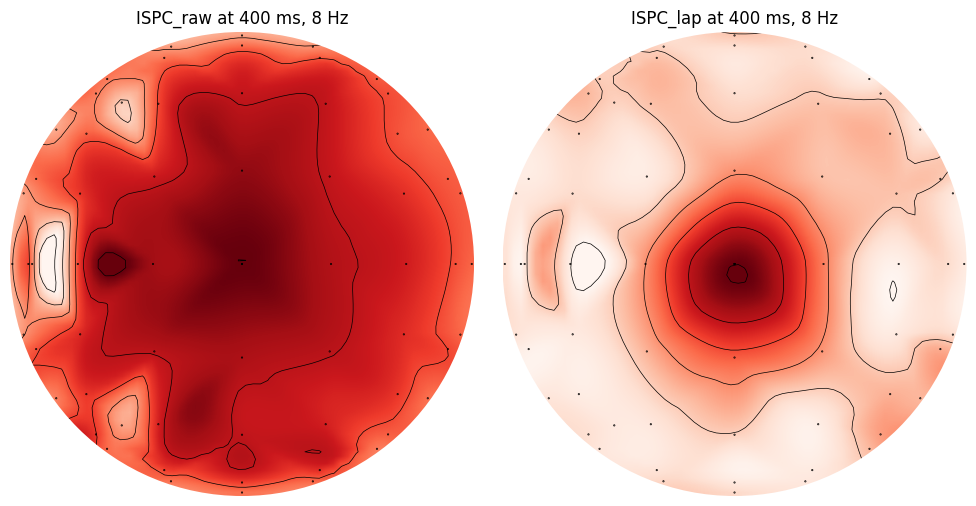

In [44]:
# Figure 22.8: Topographic maps of ISPC for a specific channel

# Plot topographic maps of ISPC for a specific channel (e.g., channel 48)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plot_topomap(ispc_pre[47, :], chanlocs, axes=ax[0], show=False)
ax[0].set_title(f'ISPC_raw at {time2use} ms, {freq2use} Hz')

plot_topomap(ispc_lap[47, :], chanlocs, axes=ax[1], show=False)
ax[1].set_title(f'ISPC_lap at {time2use} ms, {freq2use} Hz')
plt.tight_layout()
plt.show()